<a href="https://colab.research.google.com/github/jemaaku96/deeplearning/blob/main/Skin_Cancer_Transfer_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
pip install kagglehub

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [98]:
import os
import kagglehub
from sklearn.model_selection import train_test_split

path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")
print(f"Dataset downloaded to: {path}")


Dataset downloaded to: /kaggle/input/skin-cancer-malignant-vs-benign


In [100]:
print(os.listdir(path))

['data', 'test', 'train']


In [101]:
folder_benign_train = os.path.join(path, 'train', 'benign')
folder_malignant_train = os.path.join(path, 'train', 'malignant')

folder_benign_test = os.path.join(path, 'test', 'benign')
folder_malignant_test = os.path.join(path, 'test', 'malignant')


<h2> Manual Data Loading withour pre processing </h2>


In [103]:
folder_benign_train

'/kaggle/input/skin-cancer-malignant-vs-benign/train/benign'

In [104]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

In [105]:
ims_benign = []
for dirname, _, filenames in os.walk(folder_benign_train):
    for filename in filenames:
        ims_benign.append(read(os.path.join(dirname, filename)))

X_benign = np.array(ims_benign, dtype='uint8')


In [106]:
ims_malignant = []
for dirname, _, filenames in os.walk(folder_malignant_train):
    for filename in filenames:
        ims_malignant.append(read(os.path.join(dirname, filename)))

X_malignant = np.array(ims_malignant, dtype='uint8')


In [107]:
ims_benign = []
for dirname, _, filenames in os.walk(folder_benign_test):
    for filename in filenames:
        ims_benign.append(read(os.path.join(dirname, filename)))

X_benign_test = np.array(ims_benign, dtype='uint8')

In [108]:
ims_malignant = []
for dirname, _, filenames in os.walk(folder_malignant_test):
    for filename in filenames:
        ims_malignant.append(read(os.path.join(dirname, filename)))

X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [147]:
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

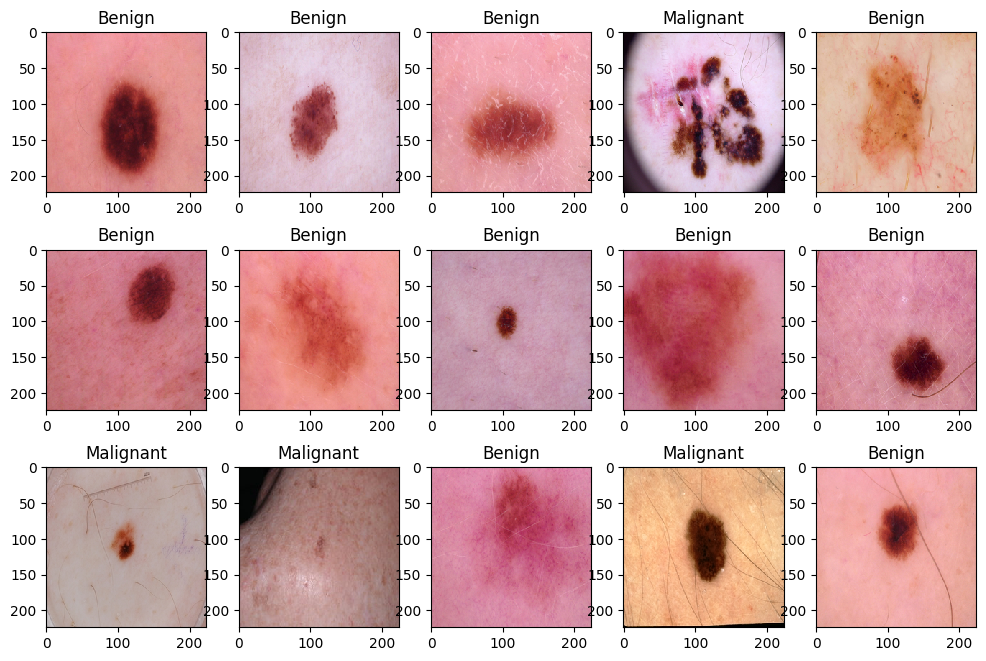

In [111]:
shuffle = np.arange(X_train.shape[0])
np.random.shuffle(shuffle)
X_train = X_train[shuffle]
y_train = y_train[shuffle]

w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [112]:
X_train.shape

(2637, 224, 224, 3)

In [113]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

<h2> This will do all the manual work and can directly input into the model </h2>

In [114]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)


test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [115]:
# dataset/
# ├── train/
# │   ├── benign/
# │   └── malignant/
# ├── test/
# │   ├── benign/
# │   └── malignant/


In [116]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'train'),             # Path to training folder
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'     # 2-class softmax output
)

Found 2637 images belonging to 2 classes.


In [117]:
validation_generator = test_datagen.flow_from_directory(
    os.path.join(path, 'test'),              # Path to test folder
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 660 images belonging to 2 classes.


In [118]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top = False,
    input_shape = (224, 224, 3),
    pooling = 'max',
    classes = 2, # This might not be strictly necessary when include_top=False
    weights = 'imagenet'
)

for layer in pretrained_model.layers:
  layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
# Changed activation to 'softmax' for compatibility with categorical_crossentropy
resnet_model.add(Dense(2, activation = 'softmax'))

In [119]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ["accuracy"])

In [121]:
r = resnet_model.fit(train_generator, validation_data = validation_generator, epochs = 10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.7668 - loss: 0.6335 - val_accuracy: 0.8485 - val_loss: 0.3341
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - accuracy: 0.8495 - loss: 0.3366 - val_accuracy: 0.8561 - val_loss: 0.3354
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 597s 2s/step - accuracy: 0.8489 - loss: 0.3433 - val_accuracy: 0.8530 - val_loss: 0.2977
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.8632 - loss: 0.2957 - val_accuracy: 0.8636 - val_loss: 0.2857
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.8788 - loss: 0.2647 - val_accuracy: 0.8712 - val_loss: 0.2766
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.8784 - loss: 0.2699 - val_accuracy: 0.8682 - val_loss: 0.2762
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.8880 - loss: 0.2555 - val_accuracy: 0.8652 - val_loss: 0.2823
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 591s 2s/step - accuracy: 0.8814 - loss: 0.2626 - val_accu

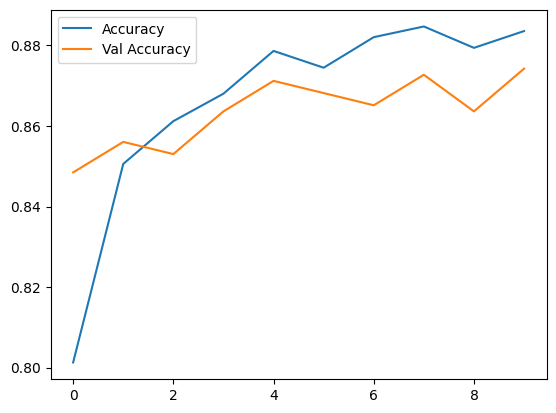

In [122]:
plt.plot(r.history["accuracy"], label = "Accuracy")
plt.plot(r.history["val_accuracy"], label = "Val Accuracy")
plt.legend()
plt.show()

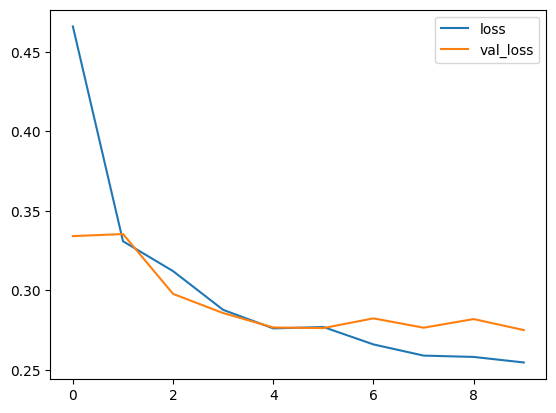

In [123]:
plt.plot(r.history["loss"], label = "loss")
plt.plot(r.history["val_loss"], label = "val_loss")
plt.legend();

In [127]:
y_pred = resnet_model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step


Confusion matrix:
[[340  20]
 [171 129]]


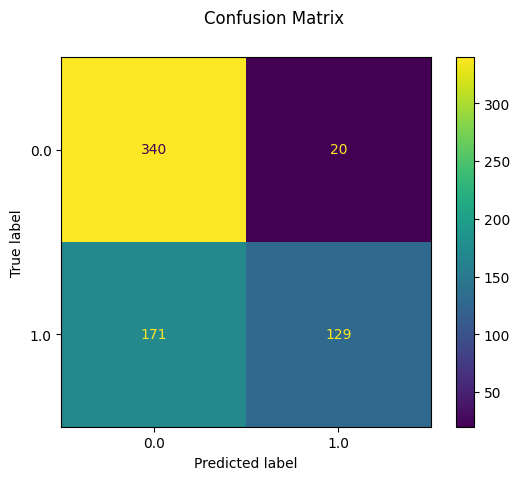

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [151]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.94      0.78       360
         1.0       0.87      0.43      0.57       300

    accuracy                           0.71       660
   macro avg       0.77      0.69      0.68       660
weighted avg       0.76      0.71      0.69       660

